In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import gzip
from tqdm import trange
np.set_printoptions(suppress=True)

In [2]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

--2023-12-27 23:54:35--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  1.17MB/s    in 14s     

2023-12-27 23:54:50 (699 KB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2023-12-27 23:54:50--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===================>]  28.20K  --.-KB/s    in 0.01s   

2023-12-27 23:54:51

In [2]:
train_images = open('train-images-idx3-ubyte.gz', 'rb').read()
train_labels = open('train-labels-idx1-ubyte.gz', 'rb').read()
test_images = open('t10k-images-idx3-ubyte.gz', 'rb').read()
test_labels = open('t10k-labels-idx1-ubyte.gz', 'rb').read()

In [3]:
# create dataset
X = np.frombuffer(gzip.decompress(train_images), dtype=np.uint8)[16:].reshape(-1, 784)
X_test = np.frombuffer(gzip.decompress(test_images), dtype=np.uint8)[16:].reshape(-1, 784)
Y = np.frombuffer(gzip.decompress(train_labels), dtype=np.uint8)[8:]
Y_test = np.frombuffer(gzip.decompress(test_labels), dtype=np.uint8)[8:]
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X = X[idx]
Y = Y[idx]
n = int(0.9*len(Y))
X_tr, Y_tr = X[:n], Y[:n]
X_val, Y_val = X[n:], Y[n:]
batch_size = 128
with torch.no_grad():
    def get_batch(split):
        xb, yb = {
            'train': (X_tr, Y_tr),
            'val': (X_val, Y_val)
        }[split]
        
        samp = np.random.randint(0, len(xb), (batch_size,))
        xb, yb = xb[samp], yb[samp]
        return xb, yb

In [4]:
n_hidden = 128
class DigiNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = nn.Sequential(*[
            nn.Linear(28 * 28, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 10),
        ])

    def forward(self, x, targets=None):
        pred = self.block(x)
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(pred, targets)
        return pred, loss

model = DigiNet()

In [5]:
loss_i, accu_i= [], []

In [6]:
optim = torch.optim.Adam(model.parameters())
max_iters = 10000

for iter in (t:= trange(max_iters)):
    xb, yb = get_batch('train')
    #print(xb.shape)
    xb, yb = torch.tensor(xb).float(), torch.tensor(yb)
    pred, loss = model(xb, yb)
    cat = torch.argmax(pred, dim=1)
    accuracy = (cat == yb).float().mean()
    optim.zero_grad(set_to_none=True)
    loss.backward()
    optim.step()
    loss_i.append(loss.item())
    accu_i.append(accuracy.item())
    t.set_description(f'loss {loss.item():.2f}, accuracy {accuracy.item():.2f}') 

loss 0.02, accuracy 0.99: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 611.81it/s]


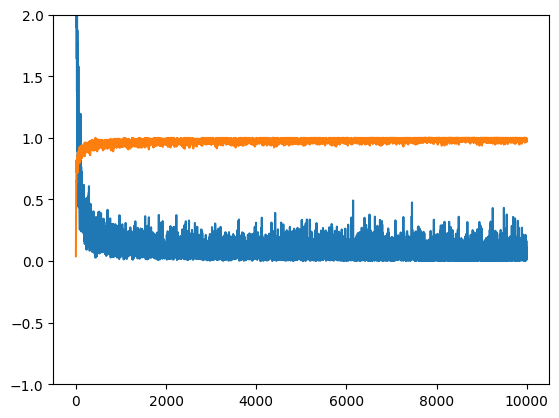

In [7]:
plt.ylim(-1,2)
plt.plot(loss_i)
plt.plot(accu_i)

In [1156]:
# a type of loss eval

eval_iters = 400
def eval_loss():
    model.eval()
    losses_tr, losses_val = [], []
    c_tr, c_val = 0, 0;
    n_tr, n_val = 0, 0;
    for _ in range(eval_iters):
        x_tr, y_tr = get_batch('train')
        x_tr, y_tr = torch.tensor(x_tr).float(), torch.tensor(y_tr)
        pred_tr, loss_tr = model(x_tr, y_tr)
        c_tr += sum(torch.argmax(pred_tr, dim=1) == y_tr)
        n_tr += x_tr.shape[0]
        losses_tr.append(loss_tr)
        
        x_val, y_val = get_batch('val')
        x_val, y_val = torch.tensor(x_val).float(), torch.tensor(y_val)
        pred_val, loss_val = model(x_val, y_val)
        c_val += sum(torch.max(F.softmax(pred_val, dim=-1), dim = 1).indices == y_val)
        n_val += x_val.shape[0]
        losses_val.append(loss_val)
    print(f'train score {c_tr} / {n_tr} val score {c_val} / {n_val}')
    print(f'train loss {torch.tensor(losses_tr).mean().item()} val loss {torch.tensor(losses_val).mean().item()}')
    model.train()

eval_loss()

train score 50393 / 51200 val score 49144 / 51200
train loss 0.07695585489273071 val loss 0.3832717835903168


In [22]:
# better way to compute test loss i guess
(torch.argmax(model(torch.tensor(X_test).float())[0], dim=1).numpy() == Y_test).mean()

0.9638

9


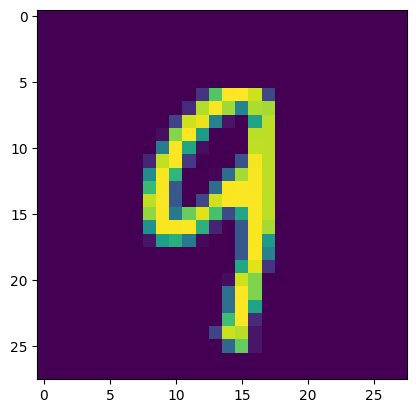

In [23]:
def classify(img):
    pred, loss = model(img)
    probs = F.softmax(pred, dim=-1)
    ix = torch.max(probs, dim=-1).indices.item()
    return ix

smp = np.random.randint(X_test.shape[0])
print(classify(torch.tensor(X_test[smp]).float()))
plt.imshow(X_test[smp].reshape(-1, 28));

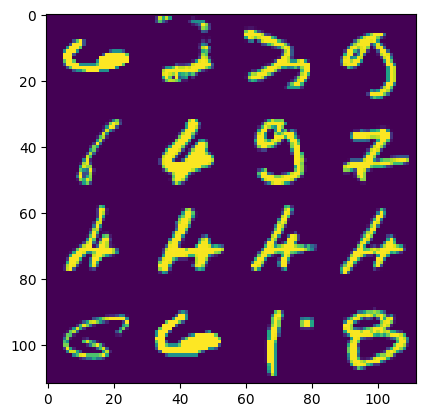

In [1160]:
shifted = Y_pred_out - np.max(Y_pred_out, axis=1, keepdims=True)
ret = - shifted[np.arange(shifted.shape[0]),Y_test] + np.log(np.exp(shifted).sum(1))

N = 4
grid = sorted(list(zip(ret, range(ret.shape[0]))), reverse=1)[0:N*N]
X_samp = X_test[[x[1] for x in grid]]
plt.imshow(np.concatenate(X_samp.reshape(-1, 28*N, 28), axis=1));

In [24]:
### no pytorch beyond this point

# hyperparams
batch_size = 128
lr = 1e-3
max_steps = 10000

# init network
w1 = np.random.randn(784,128).astype(np.float32) * (2/784)**2
b1 = np.random.randn(128).astype(np.float32) * 0.01
w2 = np.random.randn(128, 10).astype(np.float32) * 0.01
b2 = np.random.randn(10).astype(np.float32) * 0
params = [w1, b1, w2, b2]

# train

for step in (t:= trange(max_steps)):

    # minibatch
    xb, yb = get_batch('train')

    # forward
    xw1 = xb.dot(w1) + b1
    act = np.maximum(0,xw1)
    # act = np.tanh(xw1)
    logits = act.dot(w2) + b2
    accuracy = (np.argmax(logits, axis=1) == yb).astype(np.float32).mean()

    # loss
    # out_max = np.max(out, axis=1, keepdims=True)
    # logits = out - out_max
    counts = np.exp(logits) 
    counts_sum = counts.sum(axis=1, keepdims=True)
    counts_sum_inv = 1 / counts_sum
    probs = counts * counts_sum_inv
    llh = np.log(probs)
    loss = -llh[np.arange(probs.shape[0]),yb].mean()
    
    # backward
    dcounts = 0.0
    dout = 0.0

    dllh = np.zeros_like(llh)
    dllh[np.arange(probs.shape[0]),yb] = - 1 / llh[np.arange(probs.shape[0]),yb].shape[0]
    dprobs = 1 / probs * dllh
    dcounts_sum_inv = (counts * dprobs).sum(1, keepdims=True)
    dcounts = counts_sum_inv * dprobs
    dcounts_sum = (-1/counts_sum**2) * dcounts_sum_inv
    dcounts += dcounts_sum.copy()
    dlogits = counts * dcounts
   
    # dout = dlogits.copy()
    # dout_max = -1.0 * dlogits.sum(axis=1, keepdims=True)
    # dout[range(out.shape[0]), np.argmax(out, axis=1, keepdims=True)] += dout_max.copy()
    
    dact = dlogits.dot(w2.T)
    dw2 = act.T.dot(dlogits)
    db2 = dlogits.sum(0)
    
    dxw1 = (act>0).astype(np.float32) * dact
    # dxw1 = (1-act**2) * dact
    dw1 = xb.T.dot(dxw1)
    db1 = dxw1.sum(0)
    dxb = dxw1.dot(dw1.T)

    # update
    w1 += -lr * dw1
    w2 += -lr * dw2
    b1 += -lr * db1
    b2 += -lr * db2

    t.set_description(f'loss {loss.item():.2f}, accuracy {accuracy.item():.2f}') 

loss 0.02, accuracy 0.99: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:57<00:00, 174.99it/s]


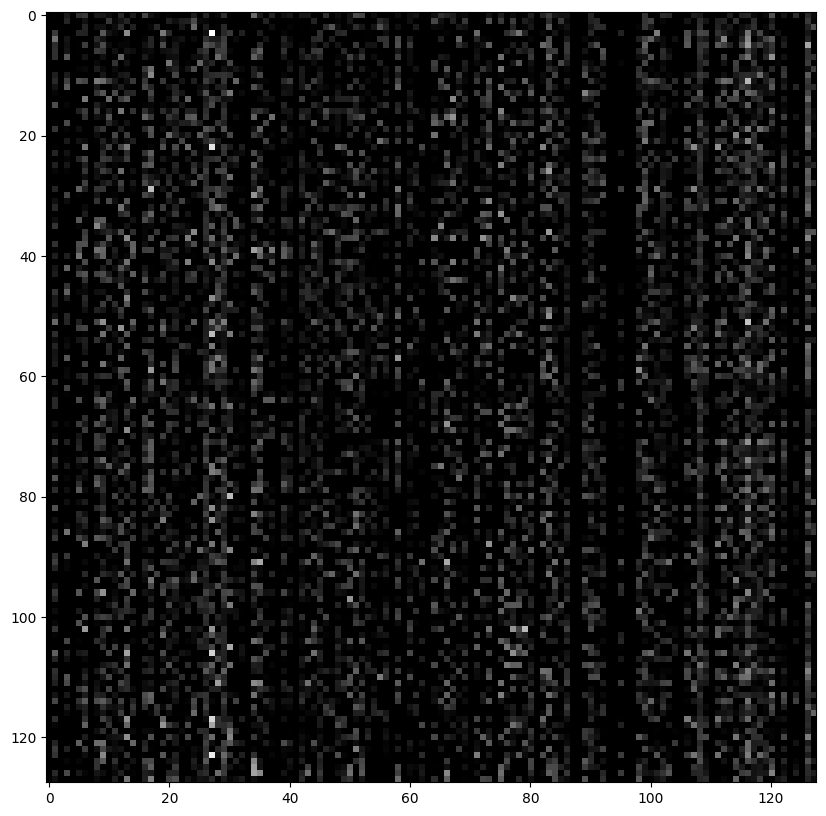

In [26]:
plt.figure(figsize=(20, 10))
plt.imshow(act, cmap='gray', interpolation='nearest');

(16384,)


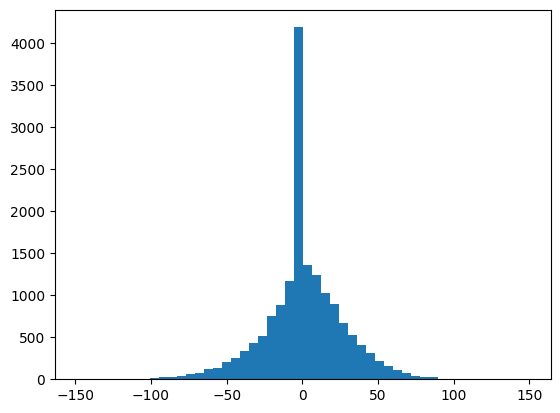

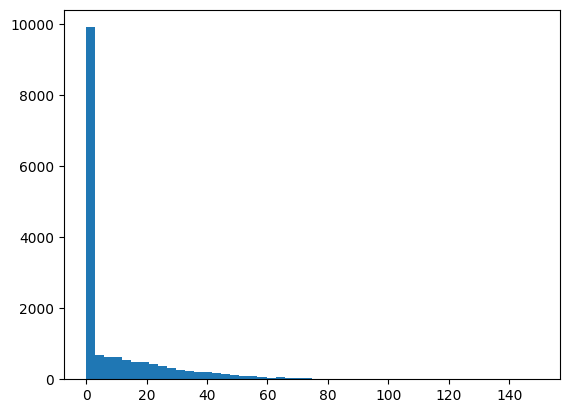

In [25]:
print(act.reshape(-1).shape)
plt.hist(xw1.reshape(-1).tolist(), 50);
plt.figure()
plt.hist(act.reshape(-1).tolist(), 50);

In [27]:
logits = np.maximum(0,X_test.dot(w1) + b1).dot(w2) + b2
(np.argmax(logits, axis=1) == Y_test).mean()

0.977

9

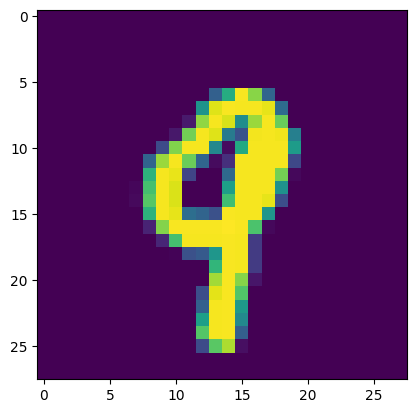

In [28]:
ix = np.random.randint(X_test.shape[0])
plt.imshow(X_test[ix].reshape(-1, 28));
np.argmax(np.maximum(0,X_test[ix].dot(w1) + b1).dot(w2) + b2)

## loss.backward()     :  0.964 
## backprop by hand    :  0.977 #swole_doge